<a href="https://colab.research.google.com/github/freddy120/svmtp2/blob/main/TP2_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trabajo Practico Nro 2 - SVM
autor: Freddy Rodrigo Mendoza Ticona

In [225]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display


%matplotlib inline

display.clear_output()



In [226]:
X_train = []
y_train = []
with open("train.csv", 'r') as f:
  f.readline()
  for i in f.readlines():
    X_train.append([float(i.split(',')[1]),  float(i.split(',')[2])])
    y_train.append(float(i.split(',')[3]))


In [227]:
X_test = []
y_test = []
with open("test.csv", 'r') as f:
  f.readline()
  for i in f.readlines():
    X_test.append([float(i.split(',')[1]),  float(i.split(',')[2])])
    y_test.append(float(i.split(',')[3]))


### Gradiente descendente

Sea la funcion de costo que queremos minimizar, necesitamos calcular su gradiente
$$
J(w,b) = \frac{1}{2} \lVert w \rVert^2 + C\sum_{i=1}^{n}max\{0,1-y_{i}(w^Tx_{i}+b)\}
$$

que es igual a: 
\begin{equation}
J(w,b) = \frac{1}{2} \lVert w \rVert^2 + C\sum_{i=1}^{n}\ell(t)
\end{equation}

donde:
$$
\ell(t) = max\{0, 1 − t\} 
$$
y 

\begin{equation}
t = y_{i}(w^Tx_{i}+b)
\end{equation}

\begin{equation}
\frac{d\ell}{dt}=\left\lbrace\begin{array}{c} -1 \ \ \ t < 1
\\ 0 \ \ \ t \geq 1 \end{array}\right.
\end{equation}

aplicamos regla de la cadena para calcular las derivadas parciales:

\begin{equation}
\frac{\partial\ell}{\partial w}=\frac{\partial\ell}{\partial t}\frac{\partial t}{\partial w} = \left\lbrace\begin{array}{c} -y_{i}x_{i} \ \ \ y_{i}(w^Tx_{i}+b)<1
\\ 0 \ \ \ y_{i}(w^Tx_{i}+b) \geq 1 \end{array}\right.
\end{equation}

y

\begin{equation}
\frac{\partial\ell}{\partial b}=\frac{\partial\ell}{\partial t}\frac{\partial t}{\partial b} = \left\lbrace\begin{array}{c} -y_{i} \ \ \ y_{i}(w^Tx_{i}+b)<1
\\ 0 \ \ \ y_{i}(w^Tx_{i}+b) \geq 1 \end{array}\right.
\end{equation}



Entonces tenemos el gradiente:
\begin{equation}
\frac{\partial J}{\partial w} = w + C\sum_{i=1}^{n}\frac{\partial \ell}{\partial w} = w - C\sum_{i=1}^{n}y_{i}x_{i} I\{y_{i}(w^Tx_{i}+b)<1\}
\end{equation}


y 

\begin{equation}
\frac{\partial J}{\partial b} = C\sum_{i=1}^{n}\frac{\partial \ell}{\partial b} = -C\sum_{i=1}^{n}y_{i}I\{y_{i}(w^Tx_{i}+b)<1\}
\end{equation}


siendo:
\begin{equation}
I\{y_{i}(w^Tx_{i}+b)<1\} = \left\lbrace\begin{array}{c} 1 \ \ \ y_{i}(w^Tx_{i}+b)<1
\\ 0 \ \ \ y_{i}(w^Tx_{i}+b) \geq 1 \end{array}\right.
\end{equation}



In [233]:
## basado en https://github.com/chZzZzZz/gradientdecent

class SvmGrad:
    def __init__(self, X, y, W=None, b=None, type='BGD',batch_size=64, alpha=0.1, epsilon=0.1, C=0.003):
      self.X = np.array(X)
      self.y = np.array(y)
      self.alpha = alpha # learning rate
      self.epsilon = epsilon
      self.C = C
      self.col = self.X.shape[1] #the number of columns of data
      self.m = self.X.shape[0] #the number of rows of data
      #self.W = np.ones((self.col, 1)) #init values
      #self.b = np.ones(1) # init values
      self.W = W #init values
      self.b = b
      self.grad = np.ones((self.col + 1, 1))
      self.type = type
      self.batch_size = batch_size

    def update_hyperparams(self):
      self.W = self.W - self.alpha * self.grad[0:2]
      self.b = self.b - self.alpha * self.grad[2] 
      return self.W, self.b

    def compute_loss(self): # compute J, entire dataset
        sumatoria = np.sum(np.amax(np.hstack((np.zeros((self.m,1)), (1 - self.y*(np.dot(self.W.T, self.X.T) + self.b)).T)), axis=1))
        return 1/2*np.dot(self.W.T, self.W) + self.C*sumatoria

    def compute_grad(self):
      if self.type == 'BGD':
        sum_part_w = [0,0]
        sum_part_b = 0
        for i in range(self.m):
          if self.y[i]*(np.dot(self.W.T, self.X[i]) + self.b)[0] < 1:
            sum_part_w += self.y[i]*self.X[i]
            sum_part_b += self.y[i]
          
        
        grad_w = self.W - self.C * np.array([sum_part_w]).T
        grad_b = -self.C * sum_part_b
      
        self.grad = np.vstack((grad_w,grad_b))

      elif self.type == 'SGD':
        r = np.random.randint(self.m)
        sum_part_w = [0,0]
        sum_part_b = 0
        X_batch = self.X[r,:]
        y_batch = self.y[r]
        
        if y_batch*(np.dot(self.W.T, X_batch) + self.b)[0] < 1:
            sum_part_w += y_batch*X_batch
            sum_part_b += y_batch
        
        grad_w = self.W - self.C * np.array([sum_part_w]).T
        grad_b = -self.C * sum_part_b
      
        self.grad = np.vstack((grad_w,grad_b))

      elif self.type == 'MINI':
        r = np.random.choice(self.m, self.batch_size, replace=False)
        sum_part_w = [0,0]
        sum_part_b = 0
        X_batch = self.X[r,:]
        y_batch = self.y[r]
        for i in range(self.batch_size):
          if y_batch[i]*(np.dot(self.W.T, X_batch[i]) + self.b)[0] < 1:
            sum_part_w += y_batch[i]*X_batch[i]
            sum_part_b += y_batch[i]
          
        
        grad_w = self.W - self.C * np.array([sum_part_w]).T
        grad_b = -self.C * sum_part_b
      
        self.grad = np.vstack((grad_w,grad_b))
      else:
          print("NO such gradient dencent Method!")
      return self.grad

    def run(self):
      self.grad = self.compute_grad()
      loss = self.compute_loss()
      self.W, self.b = self.update_hyperparams()
      loss_new = self.compute_loss()
      i = 1
      print('Init Round {} Diff Loss: {}'.format(i, np.abs(loss_new-loss)[0][0]))
      history = [[1], [loss_new[0][0]]]

      while np.abs(loss_new - loss)> self.epsilon:
        self.grad = self.compute_grad()
        self.W, self.b = self.update_hyperparams()
          
        loss = loss_new
        loss_new = self.compute_loss()
        i += 1
        history[0].append(i)
        history[1].append(loss_new[0][0])
        #print('Round {} Diff Loss: {}'.format(i, np.abs(loss_new-loss)[0][0]))
      print('final Round {} Diff Loss: {}'.format(i, np.abs(loss_new-loss)[0][0]))
      best_hyperparam = self.W, self.b
      return history, best_hyperparam

    def plot_loss(self,history):
        fig = plt.figure(figsize=(8, 6))
        plt.plot(history[0], history[1])
        plt.xlabel('Number of iterations')
        plt.ylabel('Loss')
        plt.title([self.type][0])
        plt.show()


def plot_train_points(X, Y, W, b):
  x1 = np.linspace(min(X[:,0]), max(X[:,0]), 1000)
  x2 = -W[0]/W[1]*x1 - b/W[1]
  plt.plot(x1, x2)
  plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired,
            edgecolor='black', s=20)
  plt.title("HyperPlano en X")
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.show()



##  Batch Gradient Descent (BGD)

In [234]:
start_w = np.array([[10], [3]])
start_b = np.array([0.8])
lr = 0.02
epsilon = 1e-3
C = 0.7
svmClassifier = SvmGrad(X_train, y_train, W=start_w, b=start_b, type='BGD',alpha=lr, epsilon=epsilon, C=C)
history,best_hyperparam = svmClassifier.run()

Init Round 1 Diff Loss: 25.282706766098272
final Round 36 Diff Loss: 0.00022659456848828086


Best:  W = [1.09370734 1.15166938], b = [0.478]
Classifier Accuracy = 0.925


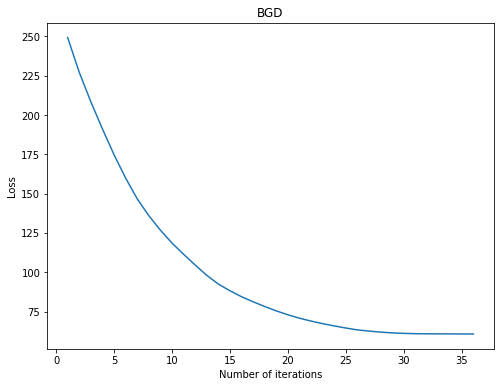

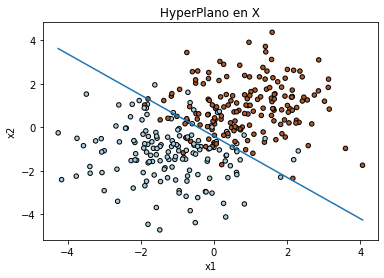

In [235]:
print("Best:  W = {}, b = {}".format(best_hyperparam[0][:,0], best_hyperparam[1]))
### Performance
Xtest = np.array(X_test)
ytest = np.array(y_test)
yresult = np.sign(np.dot(best_hyperparam[0].T, Xtest.T) + best_hyperparam[1])[0]
print("Classifier Accuracy = {}".format(np.sum(ytest == yresult)/len(ytest)))

svmClassifier.plot_loss(history)
plot_train_points(np.array(X_train), np.array(y_train), best_hyperparam[0], best_hyperparam[1])

**OBS:** Usando el batch completo puede llegar a converger más rápidamente usando un learning rate mayor, debido que hay más precisión en la estimación del gradiente usando todas las muestras. 

La curva de la función de costo en el tiempo es suave, dado las condiciones iniciales y con un C 

##  Stochastic Gradient Descent (SGD)

In [249]:
start_w = np.array([[2], [3]])
start_b = np.array([1])
lr = 0.01
epsilon = 1e-3
C = 25
svmClassifier = SvmGrad(X_train, y_train, W=start_w, b=start_b, type='SGD',alpha=lr, epsilon=epsilon, C=C)
history,best_hyperparam = svmClassifier.run()

Init Round 1 Diff Loss: 62.33443595326571
final Round 8936 Diff Loss: 0.00044283023134994437


Best:  W = [1.24279341 0.70979302], b = [0.25]
Classifier Accuracy = 0.925


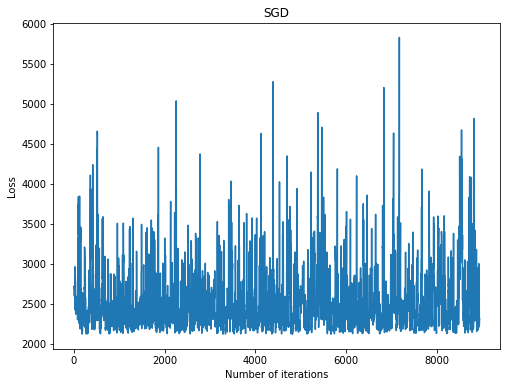

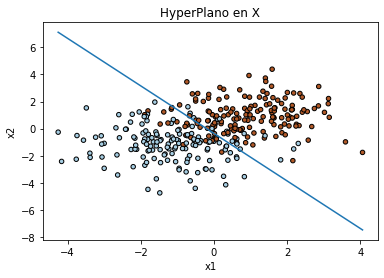

In [250]:
print("Best:  W = {}, b = {}".format(best_hyperparam[0][:,0], best_hyperparam[1]))
### Performance
Xtest = np.array(X_test)
ytest = np.array(y_test)
yresult = np.sign(np.dot(best_hyperparam[0].T, Xtest.T) + best_hyperparam[1])[0]
print("Classifier Accuracy = {}".format(np.sum(ytest == yresult)/len(ytest)))

svmClassifier.plot_loss(history)
plot_train_points(np.array(X_train), np.array(y_train), best_hyperparam[0], best_hyperparam[1])

**OBS:** usando solo una muestra para la estimación del gradiente produce más ruido en las iteraciones y además que necesitamos un parámetro de regulación (C) mayor al usado en BGD (Se entiende porque en la ecuación de la función de costo el parámetro C multiplica un sumatoria de muestras y para el caso de SGD solo se usa una muestra). Eventualmente se puede llegar a encontrar un mínimo parecido a lo encontrado con BGD jugando con los valores iniciales y el valor de C. Muchas veces no llega a converger el algoritmo. 

 
La curva de la función de costo en el tiempo es muy ruidosa. 
Notamos que toma más iteraciones en converger 

## Mini-batch Gradient Descent 

### batch = 16  y C = 7

In [263]:
start_w = np.array([[0.2], [0.3]])
start_b = np.array([0.1])
lr = 0.01
epsilon = 10e-3
C = 7
svmClassifier = SvmGrad(X_train, y_train, W=start_w, b=start_b, type='MINI', batch_size=16,alpha=lr, epsilon=epsilon, C=C)
history,best_hyperparam = svmClassifier.run()

Init Round 1 Diff Loss: 514.4577410999024
final Round 2271 Diff Loss: 0.005475030325897023


Best:  W = [1.2647576  1.07347569], b = [0.52]
Classifier Accurary = 0.9375


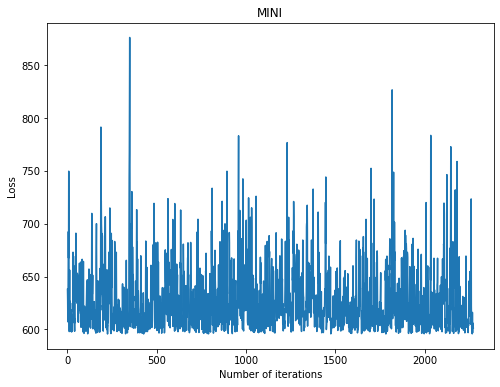

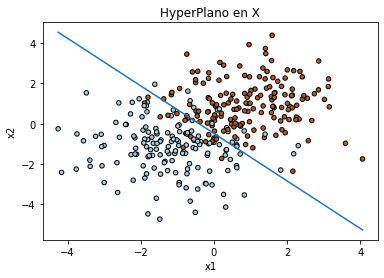

In [264]:
print("Best:  W = {}, b = {}".format(best_hyperparam[0][:,0], best_hyperparam[1]))

### Performance
Xtest = np.array(X_test)
ytest = np.array(y_test)
yresult = np.sign(np.dot(best_hyperparam[0].T, Xtest.T) + best_hyperparam[1])[0]
print("Classifier Accurary = {}".format(np.sum(ytest == yresult)/len(ytest)))

svmClassifier.plot_loss(history)
plot_train_points(np.array(X_train), np.array(y_train), best_hyperparam[0], best_hyperparam[1])




### batch = 64 y C = 0.9

In [274]:
start_w = np.array([[0.2], [0.3]])
start_b = np.array([0.1])
lr = 0.01
epsilon = 1e-3
C = 0.9
svmClassifier = SvmGrad(X_train, y_train, W=start_w, b=start_b, type='MINI', batch_size=64,alpha=lr, epsilon=epsilon, C=C)
history,best_hyperparam = svmClassifier.run()

Init Round 1 Diff Loss: 63.46194684285237
final Round 403 Diff Loss: 0.00029313257533658543


Best:  W = [0.98960826 1.01478831], b = [0.424]
Classifier Accurary = 0.925


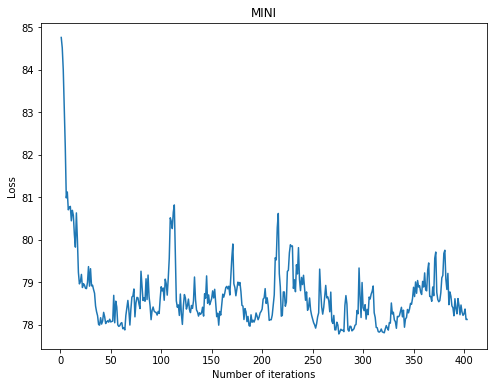

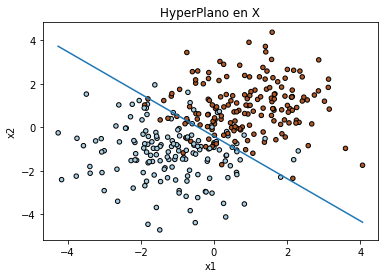

In [275]:
print("Best:  W = {}, b = {}".format(best_hyperparam[0][:,0], best_hyperparam[1]))

### Performance
Xtest = np.array(X_test)
ytest = np.array(y_test)
yresult = np.sign(np.dot(best_hyperparam[0].T, Xtest.T) + best_hyperparam[1])[0]
print("Classifier Accurary = {}".format(np.sum(ytest == yresult)/len(ytest)))

svmClassifier.plot_loss(history)
plot_train_points(np.array(X_train), np.array(y_train), best_hyperparam[0], best_hyperparam[1])



**OBS:**
Notamos que usando un tamaño de batch pequeño y con un parámetro C menor al usado en SGD se puede lograr alcanzar un mínimo, y mientras se va aumentando el batch y reduciendo el valor de C nos acercamos al resultado obtenido en BGD y con un comportamiento del costo en el tiempo menos ruidoso. 

 
 

De igual forma que con los casos anteriores, va depender de los valores iniciales y de los parametros escogidos que el algoritmo converga o no. 


## Usando SkLearn

In [203]:
Xtrain = np.array(X_train)
ytrain = np.array(y_train)
Xtest =  np.array(X_test)
ytest =  np.array(y_test)
C = 0.7
svm = SVC(C=C, kernel='linear', tol=epsilon) 
svm.fit(Xtrain, ytrain) 


SVC(C=0.7, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [204]:
print("Cantidad de vectores soporte obtenidos: {}".format(len(svm.support_vectors_))) 
print("Indices de los vectores soporte {}".format(svm.support_))

Cantidad de vectores soporte obtenidos: 90
Indices de los vectores soporte [  0   5   9  14  23  27  29  30  52  54  69  71  75  77  96 107 117 118
 164 166 174 180 181 185 199 202 218 247 248 249 254 257 259 261 266 278
 280 281 290 291 295 303 306 310 316   2  31  34  35  45  59  64  67  76
  79  92  99 104 111 120 129 132 135 138 159 184 190 194 201 204 205 207
 222 225 228 237 240 241 244 252 258 274 283 287 293 297 302 309 315 319]


In [205]:
print("Best (SVM):  W = {}, b = {}".format(svm.coef_[0], svm.intercept_))
## Performance
print("SVM Classifier Accuracy = {}".format(np.sum(svm.predict(Xtest) == ytest)/len(ytest)))


Best (SVM):  W = [1.10118234 1.14649773], b = [0.48741393]
SVM Classifier Accurary = 0.925


**OBS:** 
El resultado obtenido por sklearn y con gradiente descendente son muy similares y también el performance obtenido en ambos casos es por encima de 0.9

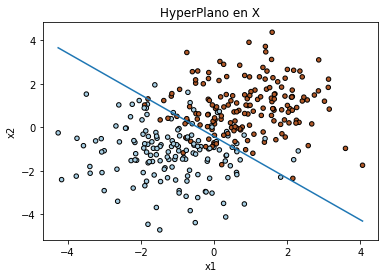

In [207]:
plot_train_points(np.array(X_train), np.array(y_train), svm.coef_.T, svm.intercept_)

### Grafica de los vectores soporte



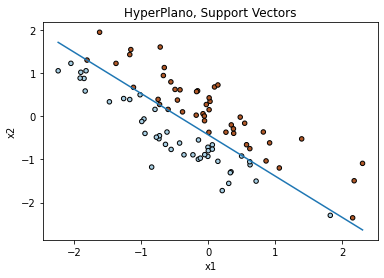

In [208]:
def plot_train_points_svm(X, Y, W, b):
  x1 = np.linspace(min(X[:,0]), max(X[:,0]), 1000)
  x2 = -W[0]/W[1]*x1 - b/W[1]
  plt.plot(x1, x2)
  plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired,
            edgecolor='black', s=20)
  plt.title("HyperPlano, Support Vectors")
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.show()


plot_train_points_svm(svm.support_vectors_, svm.predict(svm.support_vectors_), svm.coef_[0], svm.intercept_)

**OBS:**
Efectivamente los vectores soporte estan concentrados cerca al hiperplano.


### Quitando vectors soporte del Set de Entrenamiento

In [218]:
Xtrain = np.array(X_train)
ytrain = np.array(y_train)

# quitar 1 vectores soporte
index = np.random.randint(svm.support_.shape[0])
Xtrain = np.delete(Xtrain, svm.support_[index], axis=0)
ytrain = np.delete(ytrain, svm.support_[index], axis=0)

print("len X: {}".format(len(Xtrain)))
print("len y: {}".format(len(ytrain)))

len X: 319
len y: 319


In [219]:
C = 0.7
svm2 = SVC(C=C, kernel='linear', tol=epsilon) 
svm2.fit(Xtrain, ytrain) 

SVC(C=0.7, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [221]:
print("Best (SVM) Nuevo:  W = {}, b = {}".format(svm2.coef_[0], svm2.intercept_))
print("Best (SVM) Inicial:  W = {}, b = {}".format(svm.coef_[0], svm.intercept_))

## Performance
print("SVM Classifier Accuracy = {}".format(np.sum(svm2.predict(Xtest) == ytest)/len(ytest)))

Best (SVM) Nuevo:  W = [1.05840258 1.05789467], b = [0.40339286]
Best (SVM) Inicial:  W = [1.10118234 1.14649773], b = [0.48741393]
SVM Classifier Accuracy = 0.925


**OBS:**
Dependiendo de la elección del vector soporte a eliminar, puede variar el resultado obtenido más significativamente. Esto es razonable dado que son los vectores soporte los que definen el hiperplano


### Quitando vectores que no son Soporte

In [222]:
Xtrain = np.array(X_train)
ytrain = np.array(y_train)

# quitar 1 vector no soporte
index = np.random.randint(Xtrain.shape[0])
while index in svm.support_:
  index = np.random.randint(Xtrain.shape[0])

Xtrain = np.delete(Xtrain, np.array([index]), axis=0)
ytrain = np.delete(ytrain, np.array([index]), axis=0)

print("len X: {}".format(len(Xtrain)))
print("len y: {}".format(len(ytrain)))

len X: 319
len y: 319


In [223]:
C = 0.7
svm3 = SVC(C=C, kernel='linear', tol=epsilon) 
svm3.fit(Xtrain, ytrain) 

SVC(C=0.7, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [224]:
print("Best (SVM) Nuevo:  W = {}, b = {}".format(svm3.coef_[0], svm3.intercept_))
print("Best (SVM) Inicial:  W = {}, b = {}".format(svm.coef_[0], svm.intercept_))

## Performance
print("SVM Classifier Accuracy = {}".format(np.sum(svm3.predict(Xtest) == ytest)/len(ytest)))

Best (SVM) Nuevo:  W = [1.10118234 1.14649773], b = [0.48741393]
Best (SVM) Inicial:  W = [1.10118234 1.14649773], b = [0.48741393]
SVM Classifier Accurary = 0.925


**OBS:** Se comprueba que el modelo no cambia eliminando un vector que no es soporte.